# MNIST Classification via PCA Reconstruction

- 기수: 13기

- 이름: 이채원

- 작성자: 11기 김정우 ; 12기 김은희


_본 과제는 Songkuk Kim의 Programming for Data Science (IIT3308) 과제에 참조하였음을 밝힙니다._


PCA는 고차원 데이터의 특징을 최대한 보존하면서 차원을 낮추기 위한 방법인 Dimensionality Reduction의 대표적인 method 중 하나입니다.

PCA는 결과적으로 원본 데이터의 Variance를 최대한 보존할 수 있는 Principal Component들을 찾는 것을 목표로 합니다. 그리고 선정한 Principal Component들은 모두 일정한 Explained Variance를 갖게 됩니다.

각 Principal Component의 설명력은 Covariance의 관점에서 PCA를 살펴보면 알 수 있습니다.

결국 Covariance Matrix에 대한 Eigenvalue Decomposition을 수행한 결과로써 PCA를 해석할 수 있는데, 이때 설명력이 높은 순서는 Eigenvalue의 크기가 큰 순서와 동일합니다.

본 과제 문제에서는 이러한 PCA의 간단한 구현과 Explained Variance 시각화에 대한 내용, 그리고 더 나아가 Reconstruction Error를 기반으로 한 간단한 Classification Task를 다룹니다.


## 1. Introduction: What is Reconstruction Error?


- **Reconstruction Error란 PCA를 이용한 Dimensionality Reduction 이후 다시 Dimension을 원래대로 Reconstruction하는 과정에서 발생하는 오차를 의미합니다.**

<hr/>

Dimensionality Reduction은 결국 정보량의 손실 (압축) 입니다. 아무리 Variance가 높게 Principal Component를 잘 설정한다 하더라도 정보량의 손실은 불가피합니다.

724차원의 데이터에 PCA를 적용하면서 Principal Component의 개수 $N$ 을 $10, 100, 250$ 각각으로 설정함에 따라 축소된 차원에서 보존되는 정보량이 늘어나게 됩니다.

또한 $N = 724$ 로 설정하게 되면 PCA를 진행하더라도, Dimension은 축소되지 않으며, 곧 정보량 또한 손실되지 않습니다.

- **그렇다면 PCA Reconstruction이란 무엇인가요?**

<hr/>

Reduction을 거친 축소된 차원에서 다시 Principal Component를 사용한다면 원본 데이터를 복원할 수 있습니다. (PCA의 역연산)

그렇다면 Principal Component의 개수가 많을수록, 손실된 정보량이 적기 때문에 더욱 완벽한 원본 이미지를 복원할 수 있겠죠?

- **그렇다면 고양이에 대한 데이터들에 대해 구한 Principal Component로 오토바이의 사진을 복원한다면 어떻게 될까요?**

<hr/>

간단하게 오토바이와 고양이의 사진들로 구성된 데이터셋이 있다고 가정해봅시다. 고양이들의 사진을 기준으로 PCA를 진행하기 위해 Principal Component를 구했습니다.

동일한 Principal Component로 오토바이 사진에 대해 Dimensionality Reduction과 Reconstruction을 진행한다면 어떻게 될까요?

- **당연히 Reconstruction Error는 오토바이 사진보다 고양이 사진에서 훨씬 더 낮을 것입니다!**

<hr/>

본 과제에서는 이러한 특성을 이용해 각 라벨에 대한 Principal Component들을 구하고, 그를 기반으로 Reconstruction Error를 비교하여 라벨을 선택해보고자 합니다.


## 2. Load Dataset


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# Load MNIST Dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values.astype(np.float32)
y = mnist.target.astype(int)

In [4]:
print("Data Shape:", X.shape) # Data Shape
print("Label Shape:", y.shape) # Label Shape

Data Shape: (70000, 784)
Label Shape: (70000,)


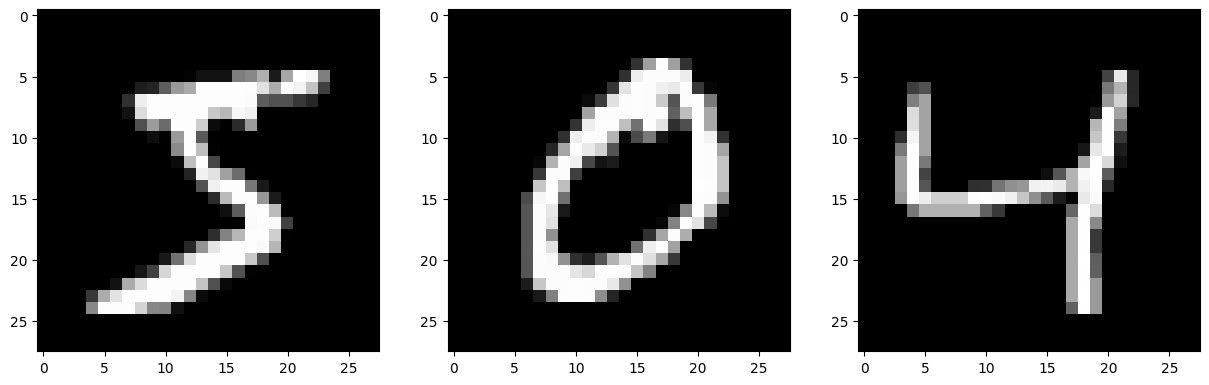

In [5]:
# Data Visualization
plt.figure(figsize=(15, 5))

for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(X[i].reshape(28, 28), cmap='gray')

plt.show()

In [6]:
# Dataset pre-process: Normalization
def normalize_data(X):
    mean = np.mean(X, axis=1, keepdims=True)
    std = np.std(X, axis=1, keepdims=True)
    std[std == 0] = 1 # Avoid division by zero
    X_normalized = (X - mean) / std
    return X_normalized

X_normalized = normalize_data(X)

In [7]:
# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=2024)

In [8]:
# Check train/test set
print("Train Dataset Shape:", X_train.shape)
print("Test Dataset Shape:", X_test.shape)

Train Dataset Shape: (49000, 784)
Test Dataset Shape: (21000, 784)


In [9]:
# Split train dataset into each labels
label_datasets_train = {label: X_train[y_train == label] for label in range(10)}

label_datasets_train[0].shape

(4815, 784)

## 3. Basic PCA


**TO DO**

본 문제에서는 PCA 라이브러리가 아닌, numpy를 이용한 행렬 단위 연산을 통해 PCA 함수를 직접 구현하고자 합니다.

<hr/>


In [10]:
def compute_pca(X, n_components):
    """
    Performs Principal Component Analysis (PCA) on the input data X.

    Parameters:
    - X: A numpy array of shape (N, F), where N is the number of samples and F is the number of features.
    - n_components: An integer specifying the number of principal components to retain.

    Returns:
    - selected_eigenvectors: A numpy array of shape (F, n_components), containing the top principal components as columns.
    - explained_variance: A numpy array of shape (n_components,), showing the explained variance ratio for the selected components.
    """
    selected_eigenvectors = np.zeros((X.shape[1], n_components))
    explained_variance = np.zeros(n_components)
    covariance_matrix = np.cov(X.T)
    #### TO DO ####
    # Hint1: np.linalg.eigh
    # Hint2: 위의 함수를 통해 고윳값 분해를 하면, eigenvalues와 eigenvectors가 나오는데,
    # 여기서 eigenvalues들은 오름차순이나 내림차순이 아닙니다. 따라서 np.argsort 같은 함수를 통해 sorting을 해야합니다.

    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sort_index = np.argsort(eigenvalues)[::-1]
    sort_eigenvalue= eigenvalues[sort_index]
    sort_eigenvector= eigenvectors[:,sort_index]
    
    selected_eigenvectors = sort_eigenvector[:, :n_components]
    explained_variance = sort_eigenvalue[:n_components] / np.sum(sort_eigenvalue)
    ###############
    return selected_eigenvectors, explained_variance


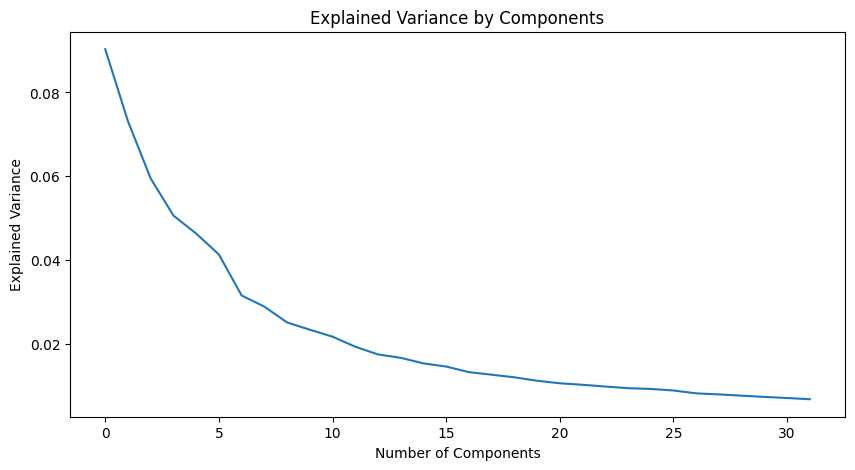

In [11]:
# Example
pca_example1, explained_variance1 = compute_pca(X_train, 32)
plt.figure(figsize=(10, 5))
plt.plot(explained_variance1)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

## 4. PCA Reconstruction


아래와 같이 PCA 기반으로 MNIST 데이터셋의 Dimension을 낮추고, 다시 복원하는 과정을 진행할 수 있습니다.

Original Image와 Reconstructed Image의 시각화에서 살펴볼 수 있듯, Reconstructed Image가 Original과 상당한 유사도를 갖게 됨을 확인할 수 있습니다.

<hr/>


**label_datasets_train의 idx와 해당 데이터셋 안에서의 idx값, principal component의 개수를 다양하게 바꿔보면서 실험해보세요!**


In [ ]:
# PCA Calculation for label 0 dataset
pca_example2, explained_variance2 = compute_pca(label_datasets_train[0], 32)

In [ ]:
# Reconstruction error function (Inverse of PCA)
def pca_reconstruction(X, eigenvectors):
    """
    Reconstructs the input data X using the provided eigenvectors and calculates the reconstruction error.

    Parameters:
    - X: A numpy array of shape (N, F), where N is the number of samples and F is the number of features.
    - eigenvectors: A numpy array of shape (F, n_components), containing the principal components.

    Returns:
    - X_reconstructed: A numpy array of shape (N, F), representing the reconstructed input data.
    - error: A numpy array of shape (N,), containing the mean squared reconstruction error for each sample.
    """
    X_reconstructed = X.copy()
    error = np.zeros(X.shape[0])
    #### TO DO ####
    # Hint1: 아래 (N, n_components) shape의 X_pca를 이용하세요.
    # Hint2: error는 X와 X_reconstructed를 비교하면 됩니다.
    X_pca = np.dot(X, eigenvectors)
    
    
    ###############
    return X_reconstructed, error

In [ ]:
reconstructed_example2, error2 = pca_reconstruction(label_datasets_train[0], pca_example2)

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(label_datasets_train[0][0].reshape(28, 28), cmap='gray')
plt.title('PCA Result')

plt.subplot(2, 2, 2)
plt.imshow(reconstructed_example2[0].reshape(28, 28), cmap='gray')
plt.title('Reconstructed Result')

plt.show()

**주어진 n_components_list에 다양한 Principal Component의 수를 적용하면서 Reconstruction 결과를 확인해보세요!**


In [ ]:
n_components_list = [9, 27, 81, 243]

fig, axs = plt.subplots(1, len(n_components_list) + 1, figsize=(15, 5))

# Original image
axs[0].imshow(label_datasets_train[0][0].reshape(28, 28), cmap='gray')
axs[0].set_title('Original')

for i, n_components in enumerate(n_components_list):
    pca_example, explained_variance = compute_pca(label_datasets_train[0], n_components)
    reconstructed_example, error = pca_reconstruction(label_datasets_train[0], pca_example)

    axs[i+1].imshow(reconstructed_example[0].reshape(28, 28), cmap='gray')
    axs[i+1].set_title(f'n = {n_components},  error = {error[0]:.2f}')

plt.show()

## 5. MNIST Classification via PCA Reconstruction Error


앞서 #4에서 살펴본 Reconstruction Error에 대해 다시 생각해보겠습니다.

MNIST 데이터셋을 기준으로, Label이 0인 데이터셋에 대해 Principal Component를 구했다고 해봅시다.

구한 Principal Component를 이용해 Reconstruction을 진행한다면, 1에 대한 데이터와 0에 대한 데이터 중 무엇이 Error가 더 낮을까요?

Principal Component를 구하는 과정에서 사용한 Label에서 훨씬 Error가 낮기에, 이점을 이용해서 Classification Task를 수행해 볼 수 있습니다.

<hr/>


In [ ]:
# PCA on each label
n_components = 60
label_pcas = {}
for label in range(10):
    label_pcas[label], _ = compute_pca(label_datasets_train[label], n_components)

In [ ]:
# Prediction function
def predict_label(X, label_pcas):
    
    predicted_labels = []
    errors = np.zeros((X.shape[0],10)) # (N, 10)
    for label in range(10):
        _, error = pca_reconstruction(X, label_pcas[label]) #(N,)
        errors[:,label] = error
    predicted_labels = np.argmin(errors, axis=1) #(N,)
    
    return predicted_labels

In [ ]:
predicted_labels = predict_label(X_test, label_pcas)

# Compute accuracy
accuracy = np.mean(np.array(predicted_labels) == y_test)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 6. Your Work!


앞서 수행한 reconstruction error based classification에 다양한 n_components를 적용해 볼 수 있습니다.

다양하게 n_components들을 변경해보세요!

In [ ]:
n_components_list = [??????] # [4,16,64]와 같이 자유롭게 변경해 보세요!
accuracy_list = []

for n_components in n_components_list:
    label_pcas = {label: compute_pca(label_datasets_train[label], n_components)[0] for label in range(10)}
    predicted_labels = predict_label(X_test, label_pcas)
    accuracy = np.mean(np.array(predicted_labels) == y_test)
    accuracy_list.append(accuracy)

    print(f"Accuracy with {n_components} components: {accuracy * 100:.2f}%")


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(n_components_list, accuracy_list, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Classification Accuracy')
plt.title('Accuracy vs. Number of Principal Components')
plt.grid(True)
plt.show()

Q. Prinicpal Component의 수와 classification의 정확도 사이에 어떤 상관관계가 있는지 자유롭게 설명해보세요.

A.